In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.cluster import adjusted_mutual_info_score as ami
from sklearn.metrics.cluster import mutual_info_score as mi
import scipy.stats as stats
import seaborn as sns
import collections
import pickle
import pandas_datareader as pdr
from datetime import datetime

In [42]:
import sys
!{sys.executable} -m pip install pyinter
!{sys.executable} -m pip install pandas_datareader

  Running setup.py bdist_wheel for requests-ftp: started
  Running setup.py bdist_wheel for requests-ftp: finished with status 'done'
  Stored in directory: C:\Users\dell\AppData\Local\pip\Cache\wheels\76\fb\0d\1026eb562c34a4982dc9d39c9c582a734eefe7f0455f711deb
Successfully built requests-ftp


In [147]:
import pyinter
import re

In [175]:
nasdaq=pd.read_csv("companylist-1.csv")
nasdaq = nasdaq[["Name","Symbol","MarketCap","Sector","industry"]]
nyse=pd.read_csv("companylist-2.csv")
nyse = nyse[["Name","Symbol","MarketCap","Sector","industry"]]

In [180]:
def captodi(s):
    num = -1
    if len(re.findall("\d+\.\d+", s)):
        num = float(re.findall("\d+\.\d+", s)[0])
        if s[-1] == 'M':
            num = num*1000000
        elif s[-1] == 'B':
            num = num*1000000000
    return num  

In [182]:
for i in range(nasdaq.shape[0]):
    nasdaq['MarketCap'][i]=captodi(nasdaq['MarketCap'][i])

In [185]:
nasdaq=nasdaq[nasdaq["MarketCap"]>1000000000]

In [184]:
for i in range(nyse.shape[0]):
    nyse['MarketCap'][i]=captodi(nyse['MarketCap'][i])

In [186]:
nyse=nyse[nyse["MarketCap"]>1000000000]

In [188]:
merge=pd.concat([nasdaq,nyse])
merge=merge.reset_index(drop=True)

In [189]:
merge["duplicate"]=merge["Name"].duplicated()
merge_clean=merge[merge["duplicate"]==False].reset_index(drop=True)
merge_clean.head()

,Name,Symbol,MarketCap,Sector,industry,duplicate
0,1st Source Corporation,SRCE,1.35e+09,Finance,Major Banks,False
1,"2U, Inc.",TWOU,3.79e+09,Technology,Computer Software: Prepackaged Software,False
2,"51job, Inc.",JOBS,4.26e+09,Technology,Diversified Commercial Services,False
3,8point3 Energy Partners LP,CAFD,1.13e+09,Public Utilities,Electric Utilities: Central,False
4,8x8 Inc,EGHT,1.62e+09,Public Utilities,Telecommunications Equipment,False


mpl.rcParams['figure.figsize'] = [10,10]
dic={}
for i in merge_clean['Symbol']:
    try:
        stock = pdr.get_data_yahoo(symbols=i, start=datetime(2016,10,31), end=datetime(2018, 1, 31))
        series=stock["Close"].to_frame()
        series.columns.values[0] = i
        dic[i]=series
        print(i)
    except:
        pass

print("total successful download",len(dic.keys()))
print("total tickers",len(merge_clean))

matrix=pd.DataFrame()
keys=list(dic.keys())
for i in range(len(keys)):
    if i==0:
        matrix=dic[keys[i]]
    else:
        matrix=matrix.join(dic[keys[i]])
    print(keys[i])

matrix_clean=matrix.dropna(axis=1, how='any')
matrix_clean.shape
matrix_clean.to_csv("universe.csv")

In [200]:
uni = pd.read_csv('universe.csv',sep = ',')
uni.set_index('Date', inplace=True)

In [201]:
uni_return = uni.apply(np.log)-uni.shift(1).apply(np.log)
uni_return=uni_return.dropna(axis=0,how='any')

_number of bars in histgram here 10 is chosen:_

In [202]:
subdays = 29
days = uni_return.shape[0]
days//subdays

10

In [10]:
rnak = uni_return.rank(ascending=0,axis=0)

_Correlation matrix_

In [203]:
corr = uni_return.corr()

In [65]:
corr.to_pickle('corr.pkl')

_Calculate the histgram rank for each cell:_

In [204]:
def tochunkvalue(value,subdays,days,low,high):
    i = 1
    gap = (high-low)/(days//subdays)
    judge = low + gap
    while(value>judge):
        i = i + 1
        judge = judge + gap
    return i
vtochunkvalue = np.vectorize(tochunkvalue)

def chunkize(serie,subdays,days):
    low = min(serie)
    high = max(serie)
    a = vtochunkvalue(serie,subdays,days,low,high)
    return a

In [205]:
chunkframe = pd.DataFrame(chunkize(uni_return['TTM'],subdays,days))
chunkframe.columns = ['TTM']
namelist = uni_return.columns
for i in namelist:
    temp = pd.DataFrame(chunkize(uni_return[i],subdays,days))
    chunkframe[i]=temp
chunkframe.set_index(uni_return.index,inplace = True)

_All combinations:_

In [12]:
pairsdo = list()
length = namelist.size
daylength = uni_return.shape[0]
for i in range(0,length):
    for j in range(i, length):
        pairsdo.append((i,j))

In [13]:
a = np.mat(chunkframe)
namelist = chunkframe.columns
D = np.zeros((length,length))
ami(np.array(a[:,1]).reshape(314,),np.array(a[:,2]).reshape(314,))

0.042599537678240061

In [14]:
seg = 50
df_split = np.array_split(pairsdo, seg)

i = 0
for p in df_split[0]:
    print(i)
    i = i+1
    D[p[0],p[1]]=ami(np.array(a[:,p[0]]).reshape(daylength,),np.array(a[:,p[1]]).reshape(daylength,))

_This loop will take an hour to run:_

In [50]:
for bigi in range(seg):
    for p in df_split[bigi]:
        D[p[0],p[1]]=ami(np.array(a[:,p[0]]).reshape(daylength,),np.array(a[:,p[1]]).reshape(daylength,))
    np.save('mat{}.npy'.format(bigi), D)

In [15]:
D = np.load('mat49.npy')

In [16]:
muinfo = pd.DataFrame(D)
muinfo.columns = chunkframe.columns
muinfo.index = chunkframe.columns
#muinfo.to_pickle('mutualinfo.pkl')

In [101]:
newpairs = list()
for i in range(0,length):
    for j in range(i+1, length):
        newpairs.append((namelist[i],namelist[j]))
numl = len(newpairs)

In [14]:
muinfo['MRK']['TTM']

0.0089758143947346516

_Universe result:_

In [15]:
filteresult = {(p[0],p[1]):[corr[p[0]][p[1]],muinfo[p[1]][p[0]]] for p in newpairs }

In [278]:
#with open('filteresult.pickle', 'wb') as handle:
#    pickle.dump(filteresult, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
with open('filteresult.pickle', 'rb') as handle:
    filteresult = pickle.load(handle)
filteresult

{('TTM', 'MRK'): [-0.015860566051505272, 0.0089758143947346516],
 ('TTM', 'PDCO'): [0.063840331942750975, 0.00026400741074291317],
 ('TTM', 'SCI'): [-0.041512378366911511, 0.018967462778563104],
 ('TTM', 'INFO'): [0.13350033184430601, 0.0054418248512563532],
 ('TTM', 'NVG'): [0.1865506132233592, 0.0075800145818071211],
 ('TTM', 'D'): [0.059305890367353606, -0.0049434750028299309],
 ('TTM', 'MC'): [0.086446818347149776, -0.0043387703684562157],
 ('TTM', 'TOWN'): [0.058626056974807925, 0.011401586266306702],
 ('TTM', 'PAA'): [0.07076258980770167, -0.0010913924192143764],
 ('TTM', 'MNK'): [0.13179757701058559, -0.0033483452343169096],
 ('TTM', 'CRZO'): [0.1469790983148726, 0.0028224323749305351],
 ('TTM', 'CAR'): [0.030202987207935541, 0.025741738186556971],
 ('TTM', 'IBTX'): [0.11663076627965971, 0.014588924403274065],
 ('TTM', 'IPG'): [0.080842215280393259, -0.0059030047336329425],
 ('TTM', 'TNET'): [0.10306620184965641, 0.020349235662470825],
 ('TTM', 'AJRD'): [0.10137483268790556, 0.0

_now we need to adjust the result since we don't want ETF appears in the result_

In [84]:
nasdaq=pd.read_csv("companylist-1.csv")
etflist = set()
for i in range(nasdaq.shape[0]):
    if nasdaq['Sector'][i]=='n/a':
        etflist.add(nasdaq['Symbol'][i])

nyse =pd.read_csv("companylist-2.csv")
for i in range(nyse.shape[0]):
    if nyse['Sector'][i]=='n/a':
        etflist.add(nyse['Symbol'][i])

In [102]:
filteresult2 = {}

for k,v in filteresult.items():
    if k[0] in etflist or k[1] in etflist:
        continue
    else:
        filteresult2[k]=v

temp = filteresult
filteresult = filteresult2
filteresult2 = temp

In [114]:
with open('filteresult2.pickle', 'wb') as handle:
    pickle.dump(filteresult, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [104]:
newpairs = []
for k in filteresult:
    newpairs.append(k)
numl = len(newpairs)

_array of all adjusted mutual information ratio_

In [105]:
tt = [muinfo[p[1]][p[0]] for p in newpairs]

In [106]:
muinfosum = {'mean':np.mean(tt),'std':np.std(tt),'median':np.median(tt),'max':max(tt),'min':min(tt)}
muinfosum

{'max': 0.5984014525774638,
 'mean': 0.014122361043752417,
 'median': 0.010203614777638814,
 'min': -0.02964282831040967,
 'std': 0.02075209296281099}

_array of all correlation ratio_

In [107]:
ss = [corr[p[1]][p[0]] for p in newpairs]

In [108]:
corinfosum = {'mean':np.mean(ss),'std':np.std(ss),'median':np.median(ss),'max':max(ss),'min':min(ss)}
corinfosum

{'max': 0.98374948796804673,
 'mean': 0.12600641299657173,
 'median': 0.11490012601394456,
 'min': -0.46963406812094638,
 'std': 0.11646867705491852}

In [109]:
corronethird = np.percentile(ss,33)
corrtwothird = np.percentile(ss,66)
muionethird = np.percentile(tt,33)
muitwothird = np.percentile(tt,66)

_let's divide the result into 100 blocks with respect to quantile:_

In [110]:
divideq = []
howmanygroup = 10
barr = 100.0/howmanygroup

ruler = []
ruler.append(0)
for i in range(howmanygroup):
    ruler.append((i+1)*barr)

corruler = []
for i in range(howmanygroup+1):
    corruler.append(np.percentile(ss,ruler[i]))

muiruler = []
for i in range(howmanygroup+1):
    muiruler.append(np.percentile(tt,ruler[i]))

corrinter = []
for i in range(howmanygroup):
    corrinter.append(pyinter.closed(corruler[i],corruler[i+1]))

muinter = []
for i in range(howmanygroup):
    muinter.append(pyinter.closed(muiruler[i],muiruler[i+1]))

In [111]:
resultmap = pd.DataFrame(np.zeros((howmanygroup,howmanygroup)))

In [112]:
lrow = 0;
lcol = 0;
for p in newpairs:
    for i in range(howmanygroup):
        if filteresult[p][0] in corrinter[i]:
            lcol = i
    for j in range(howmanygroup):
        if filteresult[p][1] in muinter[j]:
            lrow = j
    resultmap[lcol][lrow]=resultmap[lcol][lrow]+1
resultmap

,0,1,2,3,4,5,6,7,8,9
0,28737.0,36668.0,33299.0,27301.0,20473.0,13822.0,7733.0,2896.0,468.0,6.0
1,25719.0,29162.0,27949.0,25745.0,22669.0,18469.0,13059.0,6851.0,1740.0,39.0
2,23395.0,24273.0,23869.0,23937.0,23166.0,20797.0,16880.0,11052.0,3886.0,148.0
3,21385.0,20843.0,21292.0,21992.0,22276.0,21969.0,19471.0,14847.0,6839.0,488.0
4,19476.0,17740.0,18674.0,19754.0,20783.0,21797.0,21920.0,19126.0,11064.0,1069.0
5,17199.0,14992.0,15711.0,17422.0,19383.0,21168.0,23245.0,23003.0,16579.0,2700.0
6,14526.0,11883.0,12919.0,14575.0,17094.0,19833.0,23374.0,26801.0,24500.0,5898.0
7,11464.0,8958.0,9849.0,11398.0,13633.0,17218.0,21961.0,28692.0,34241.0,13988.0
8,7537.0,5470.0,6178.0,7206.0,9124.0,12292.0,17377.0,26647.0,43857.0,35715.0
9,1965.0,1413.0,1663.0,2072.0,2802.0,4037.0,6383.0,11487.0,28229.0,111352.0


In [113]:
np.save('bigmatrixquantile.npy', resultmap)

In [117]:
ax = sns.heatmap(resultmap, annot=False)
ax.set(ylabel="adjusted mutual information", xlabel="correlation")

[Text(33,0.5,'adjusted mutual information'), Text(0.5,15,'correlation')]

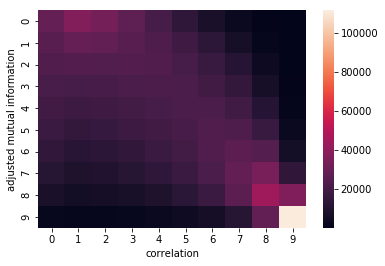

In [118]:
plt.show()

_cut the universe into 9 blocks with respect to quantile_

In [119]:
hh ={}
hm ={}
hl ={}
mh ={}
mm ={}
ml ={}
lh ={}
lm ={}
ll ={}

for p in newpairs:
    if filteresult[p][0]>= corrtwothird and filteresult[p][1]>=muitwothird:
        hh[p]=filteresult[p]
    elif filteresult[p][0]>= corrtwothird and filteresult[p][1]<muitwothird and filteresult[p][1]>=muionethird:
        hm[p]=filteresult[p]
    elif filteresult[p][0]>= corrtwothird and filteresult[p][1]<muionethird:
        hl[p]=filteresult[p]
    elif filteresult[p][0]<corrtwothird and filteresult[p][0]>=corronethird and filteresult[p][1]>=muitwothird:
        mh[p]=filteresult[p]
    elif filteresult[p][0]<corrtwothird and filteresult[p][0]>=corronethird and filteresult[p][1]<muitwothird and filteresult[p][1]>=muionethird:
        mm[p]=filteresult[p]
    elif filteresult[p][0]<corrtwothird and filteresult[p][0]>=corronethird and filteresult[p][1]<muionethird:
        ml[p]=filteresult[p]
    elif filteresult[p][0]<corronethird and filteresult[p][1]>=muitwothird:
        lh[p]=filteresult[p]
    elif filteresult[p][0]<corronethird and filteresult[p][1]<muitwothird and filteresult[p][1]>=muionethird:
        lm[p]=filteresult[p]
    elif filteresult[p][0]<corronethird and filteresult[p][1]<muionethird:
        ll[p]=filteresult[p]
    

In [120]:
with open('hh.pickle', 'wb') as handle:
    pickle.dump(hh, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('hh.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)
unserialized_data

In [121]:
showheat = pd.DataFrame(np.zeros((3,3)),columns = ['high','median','low'],index = ['high','median','low'])
showheat['high']['high']=len(hh)
showheat['high']['median']=len(hm)
showheat['high']['low']=len(hl)
showheat['median']['high']=len(mh)
showheat['median']['median']=len(mm)
showheat['median']['low']=len(ml)
showheat['low']['high']=len(lh)
showheat['low']['median']=len(lm)
showheat['low']['low']=len(ll)
ax = sns.heatmap(showheat, annot=True)
ax.set(xlabel="adjusted mutual information", ylabel="correlation")
showheat

,high,median,low
high,383416.0,122815.0,76538.0
median,151287.0,224220.0,190121.0
low,48066.0,218593.0,298970.0


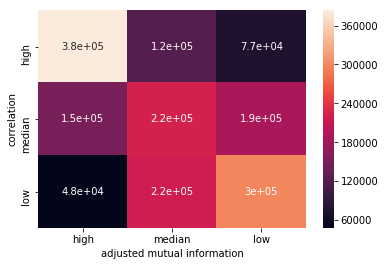

In [122]:
plt.show()

_We have 49959 pairs with low correlation but high adjusted mutual information (relatively)_

In [123]:
sample = list(filteresult.values())

In [124]:
mui = [p[1] for p in sample]
corre = [p[0] for p in sample]

In [125]:
colors = np.random.rand(len(mui))
plt.scatter(mui, corre, c = colors)
plt.title("adjusted mutual information vs. Correlation")
plt.xlabel("adjusted mutual information")
plt.ylabel("Correlation")

Text(0,0.5,'Correlation')

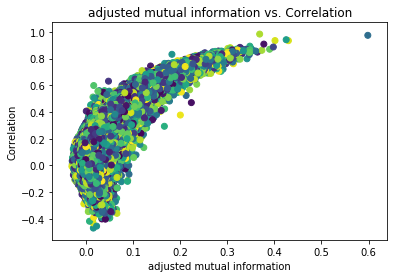

In [126]:
plt.show()

_According to graph, first cut correlation at 0.4, ami at 0.15_

In [128]:
cavecorr = pd.DataFrame(np.zeros((length,length)),index = chunkframe.columns, columns = chunkframe.columns)
cavemuti = pd.DataFrame(np.zeros((length,length)),index = chunkframe.columns, columns = chunkframe.columns)

In [206]:
cave = {}
for p in newpairs:
    if filteresult[p][0]>=0.4 or filteresult[p][0]<-0.4 or filteresult[p][1]>=0.15:
        cave[p]=filteresult[p]
        cavecorr[p[0]][p[1]]=filteresult[p][0]
        cavemuti[p[0]][p[1]]=filteresult[p][1]
bb = [b for b in cave.values()]

In [207]:
bb0 = [b[0] for b in bb]
bb1 = [b[1] for b in bb]

In [208]:
muinfosum2 = {'mean':np.mean(bb1),'std':np.std(bb1),'median':np.median(bb1),'max':max(bb1),'min':min(bb1)}
muinfosum2

{'max': 0.5984014525774638,
 'mean': 0.096008597814938271,
 'median': 0.07856784646797163,
 'min': 0.00090790938616883414,
 'std': 0.052693129866191471}

In [209]:
corrfosum2 = {'mean':np.mean(bb0),'std':np.std(bb0),'median':np.median(bb0),'max':max(bb0),'min':min(bb0)}
corrfosum2

{'max': 0.98374948796804673,
 'mean': 0.50659728378877411,
 'median': 0.4659726846938354,
 'min': -0.46963406812094638,
 'std': 0.10762191502100188}

In [210]:
sample2 = list(cave.values())
mui2 = [p[1] for p in sample2]
corre2 = [p[0] for p in sample2]

colors = np.random.rand(len(cave))
plt.scatter(mui2, corre2, c = colors)
plt.title("adjusted mutual information vs. Correlation")
plt.xlabel("adjusted mutual information")
plt.ylabel("Correlation")

Text(0,0.5,'Correlation')

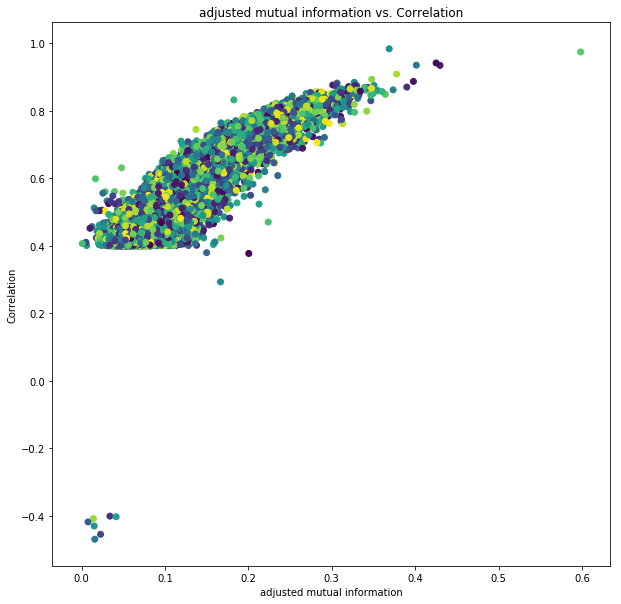

In [211]:
plt.show()

_let's see the top 50 pairs for correlation and ami_

In [135]:
corrdc1 = collections.OrderedDict(sorted(cave.items(), key=lambda k :k[1][0], reverse=True))
list(corrdc1.items())[0:50]

[(('UL', 'UN'), [0.98374948796804673, 0.36887225322584377]),
 (('BBL', 'BHP'), [0.97443729396587764, 0.5984014525774638]),
 (('LBRDA', 'CHTR'), [0.94163749868629321, 0.42516824754988408]),
 (('BBD', 'ITUB'), [0.93518114619343862, 0.40143771885870833]),
 (('RELX', 'RENX'), [0.93449934239851529, 0.42986416945283801]),
 (('CMS', 'XEL'), [0.90859383862520393, 0.37772435060725945]),
 (('JPM', 'BAC'), [0.89330501941248552, 0.34802504615859042]),
 (('XEL', 'ED'), [0.88694299695209566, 0.39791918721699748]),
 (('LNT', 'XEL'), [0.88422999456544116, 0.32706562623949387]),
 (('WEC', 'ED'), [0.88200191943348516, 0.30641046086541973]),
 (('LNT', 'CMS'), [0.87622595374308665, 0.30125222979857963]),
 (('SNV', 'PB'), [0.87528879427859152, 0.35073404506112771]),
 (('AEP', 'XEL'), [0.87471216717816458, 0.32988948554375097]),
 (('CMA', 'CFG'), [0.87469439066641486, 0.32815494758096775]),
 (('BXS', 'PB'), [0.87329712689987682, 0.3052761650455873]),
 (('LNT', 'WEC'), [0.87155752171102874, 0.320406857159422

In [136]:
amidc1 = collections.OrderedDict(sorted(cave.items(), key=lambda k :k[1][1], reverse=True))
list(amidc1.items())[0:50]

[(('BBL', 'BHP'), [0.97443729396587764, 0.5984014525774638]),
 (('RELX', 'RENX'), [0.93449934239851529, 0.42986416945283801]),
 (('LBRDA', 'CHTR'), [0.94163749868629321, 0.42516824754988408]),
 (('BBD', 'ITUB'), [0.93518114619343862, 0.40143771885870833]),
 (('XEL', 'ED'), [0.88694299695209566, 0.39791918721699748]),
 (('RF', 'STI'), [0.87022428947814678, 0.390017283574847]),
 (('CMS', 'XEL'), [0.90859383862520393, 0.37772435060725945]),
 (('SNV', 'FULT'), [0.86207801797082495, 0.3735867986407484]),
 (('UL', 'UN'), [0.98374948796804673, 0.36887225322584377]),
 (('SNV', 'STI'), [0.84867330060102797, 0.36419253972799254]),
 (('STI', 'HBAN'), [0.85683450278457629, 0.3603606484894562]),
 (('SNV', 'CMA'), [0.86007993477783717, 0.35517526363019608]),
 (('SNV', 'PB'), [0.87528879427859152, 0.35073404506112771]),
 (('KEY', 'HBAN'), [0.85249511014986101, 0.35002418368085758]),
 (('JPM', 'BAC'), [0.89330501941248552, 0.34802504615859042]),
 (('SNV', 'HBAN'), [0.84789893360729596, 0.3479153116749

_Conclusion:_

_First take all pairs whose correlation is larger than 0.4 or adjusted mutual information larger than 0.15_

In [137]:
with open('cave.pickle', 'wb') as handle:
    pickle.dump(cave, handle, protocol=pickle.HIGHEST_PROTOCOL)